In [191]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import pymysql
from sqlalchemy import create_engine
import getpass
password = getpass.getpass()

········


In [192]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [193]:
# extract information relevant to building the prediction model
query1 = pd.read_sql_query(
'''
SELECT 
    f.film_id, f.title, c.name AS category, f.rating, f.rental_rate, f.rental_duration, r.rental_date
FROM 
    film f
JOIN
    film_category fc ON f.film_id = fc.film_id
JOIN
    category c ON fc.category_id = c.category_id
JOIN 
    inventory i ON f.film_id = i.film_id
JOIN 
    rental r ON i.inventory_id = r.inventory_id;
''', con = engine
)

In [194]:
# read data into pandas dataframe
data = pd.DataFrame(query1)
display(data.head())

,film_id,title,category,rating,rental_rate,rental_duration,rental_date
0,19,AMADEUS HOLY,Action,PG,0.99,6,2005-08-02 01:16:59
1,19,AMADEUS HOLY,Action,PG,0.99,6,2005-08-18 04:26:54
2,19,AMADEUS HOLY,Action,PG,0.99,6,2005-06-20 20:35:28
3,19,AMADEUS HOLY,Action,PG,0.99,6,2005-07-09 05:01:58
4,19,AMADEUS HOLY,Action,PG,0.99,6,2005-07-30 08:02:39


Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.  

In [195]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   film_id          16044 non-null  int64         
 1   title            16044 non-null  object        
 2   category         16044 non-null  object        
 3   rating           16044 non-null  object        
 4   rental_rate      16044 non-null  float64       
 5   rental_duration  16044 non-null  int64         
 6   rental_date      16044 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 877.5+ KB


None

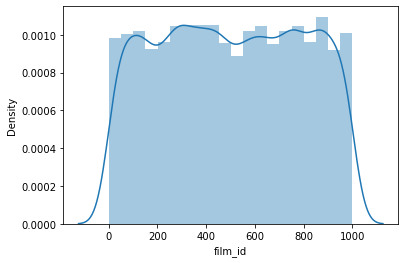

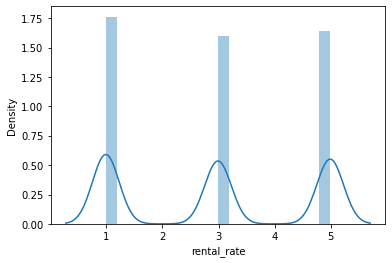

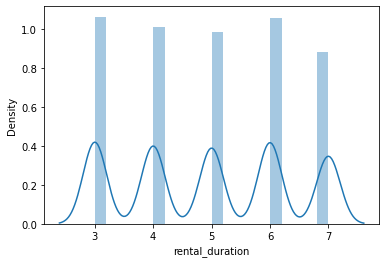

In [196]:
for column in data._get_numeric_data():
    sns.distplot(numerical[column], bins=20)
    plt.show()

In [197]:
# converting rental_duration type from numeric to categorical
def rental_duration_cat(x):
    x = str(x)
    return x 

data['rental_duration'] = data['rental_duration'].apply(rental_duration_cat)
data['rental_duration'].dtype

dtype('O')

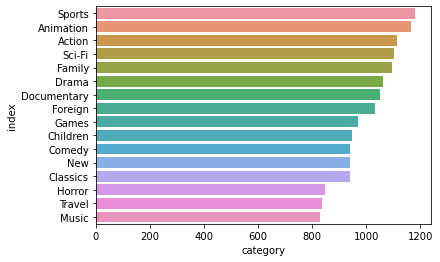

<Figure size 432x288 with 0 Axes>

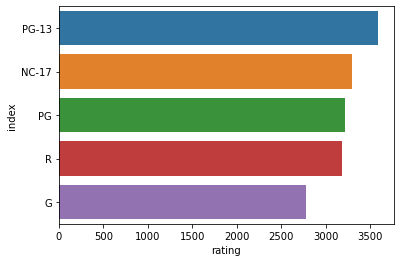

<Figure size 432x288 with 0 Axes>

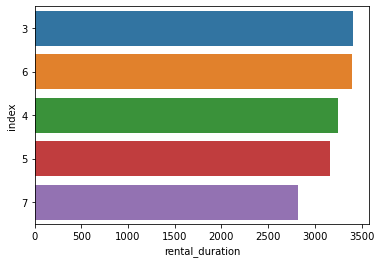

<Figure size 432x288 with 0 Axes>

In [198]:
col = ['category', 'rating', 'rental_duration']
for column in col:
    my_data = data[column].value_counts().reset_index()
    ax = sns.barplot(x=column, y="index", data = my_data)
    plt.figure()
    plt.show()
    display()

In [199]:
# creating instance of one hot encoder
enc = OneHotEncoder()

# assigning numerical values
for column in data.select_dtypes(object):
    data[column] = pd.DataFrame(enc.fit_transform(data[[column]]).toarray())
display(data.head())

,film_id,title,category,rating,rental_rate,rental_duration,rental_date
0,19,0.0,1.0,0.0,0.99,0.0,2005-08-02 01:16:59
1,19,0.0,1.0,0.0,0.99,0.0,2005-08-18 04:26:54
2,19,0.0,1.0,0.0,0.99,0.0,2005-06-20 20:35:28
3,19,0.0,1.0,0.0,0.99,0.0,2005-07-09 05:01:58
4,19,0.0,1.0,0.0,0.99,0.0,2005-07-30 08:02:39


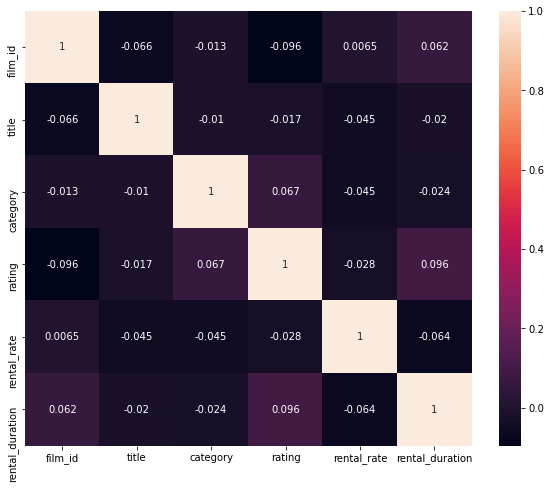

In [200]:
# checking correlation among features
corr_matrix = data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable. 

In [201]:
data['rental_date'] = data['rental_date'].dt.normalize()
data['month'] = data['rental_date'].dt.month
data['year'] = data['rental_date'].dt.year
display(data.head())

,film_id,title,category,rating,rental_rate,rental_duration,rental_date,month,year
0,19,0.0,1.0,0.0,0.99,0.0,2005-08-02,8,2005
1,19,0.0,1.0,0.0,0.99,0.0,2005-08-18,8,2005
2,19,0.0,1.0,0.0,0.99,0.0,2005-06-20,6,2005
3,19,0.0,1.0,0.0,0.99,0.0,2005-07-09,7,2005
4,19,0.0,1.0,0.0,0.99,0.0,2005-07-30,7,2005


In [202]:
display(data['rental_date'].min())
display(data['rental_date'].max())

Timestamp('2005-05-24 00:00:00')

Timestamp('2006-02-14 00:00:00')

In [203]:
data['rent_last_month'] = np.where((data['year'] == 2006) & (data['month'] == 2), 'yes', 'no')
display(data.head())

,film_id,title,category,rating,rental_rate,rental_duration,rental_date,month,year,rent_last_month
0,19,0.0,1.0,0.0,0.99,0.0,2005-08-02,8,2005,no
1,19,0.0,1.0,0.0,0.99,0.0,2005-08-18,8,2005,no
2,19,0.0,1.0,0.0,0.99,0.0,2005-06-20,6,2005,no
3,19,0.0,1.0,0.0,0.99,0.0,2005-07-09,7,2005,no
4,19,0.0,1.0,0.0,0.99,0.0,2005-07-30,7,2005,no


In [204]:
# split data into features and target
y = data['rent_last_month']
X = data.drop(['rent_last_month', 'rental_date', 'month', 'year', 'film_id'], axis=1)

Create a logistic regression model to predict this variable from the cleaned data.  
Evaluate the results.

In [205]:
# separate the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification = LogisticRegression()
classification.fit(X_train, y_train)

LogisticRegression()

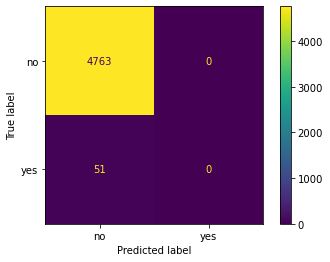

In [206]:
predictions = classification.predict(X_test)

plot_confusion_matrix(classification, X_test, y_test)
plt.show()

In [207]:
display('Kappa of the model: %4.1f' % cohen_kappa_score(y_test, predictions))
display('Accuracy score: %4.2f' % accuracy_score(y_test, predictions))

'Kappa of the model:  0.0'

'Accuracy score: 0.99'